<div class="alert alert-success">
<h1>Gaussian Process Regression Lab</h1>
<h2>ASI Lab - 04/05/2017</h2>
</div>

<h2>1. Aims</h2>
<p>
<ul>
<li>To sample from a Gaussian process prior distribution.
<li>To implement Gaussian process inference for regression.
<li>To use the above to observe samples from a Gaussian process posterior distribution.
<li>To evaluate how diﬀerent hyperparameter settings impact model quality.
</ul>

<h2>2. Introduction</h2>
<p>
Gaussian processes (henceforth GPs) achieve greater ﬂexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (inﬁnite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression. For the sake of clarity, we shall focus on univariate data, which enables better visualisation of the GP. Nonetheless, the code implemented within this lab can very easily be extended to handle multi-dimensional inputs.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.io as sio
from scipy.stats import beta
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 8.0)

<h2>3. Sampling from GP Prior</h2>

<div class="alert alert-success">
We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by a function
<br><br>
\begin{equation}
f(x) = sin (\exp{0.03x})
\end{equation}
<br>
Generate 200 random points, x, in the range [-20, 80], and compute their corresponding function values, t. The target function can then be plotted accordingly.
</div>

In [74]:
def fun(x):
    return np.sin(np.exp(0.03*x))

x = np.random.uniform(low=-20, high=80, size=200)
t = [fun(_) for _ in x]

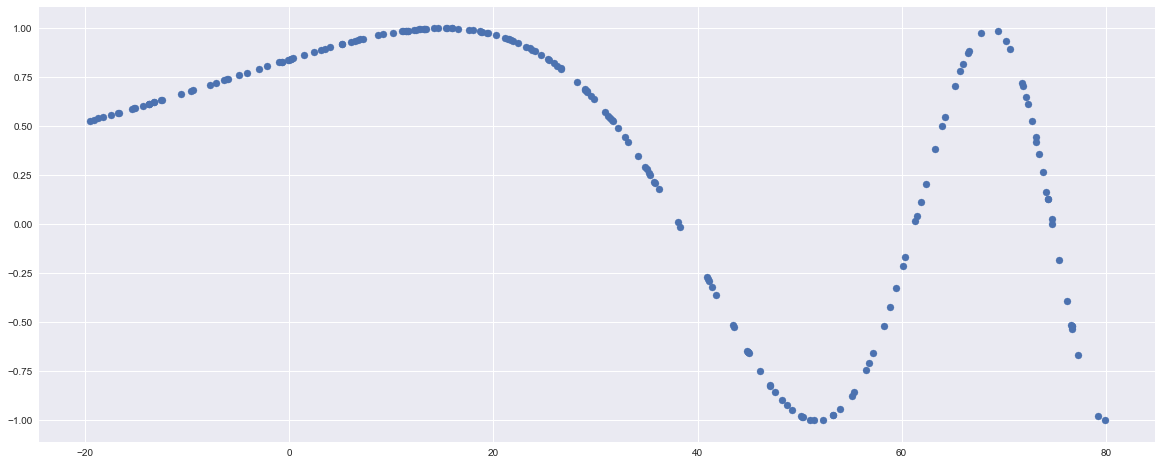

In [75]:
#PLOTTING
plt.figure()
plt.scatter(x, t)
plt.show()

<div class="alert alert-success">
Recall that since GPs are non-parametric, we deﬁne a prior distribution over functions (models), speciﬁed as a multivariate Gaussian distribution
<br><br>
\begin{equation}
p(f) = \mathcal{N}(\mu, \Sigma).
\end{equation}
<br>
Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu$ = 0. The covariance matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the input points. For this tutorial, we shall consider the widely used squared-exponential (RBF) covariance (also referred to as the kernel function), which is deﬁned between two points as:
<br><br>
\begin{equation}
k(x − x^{'}) = \sigma_f^2 \exp \left( - \frac{(x-x^{'})^2}{2l^2} \right).
\end{equation}
<br>
This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma^2_f$ . Given that the true 2 function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma^2_n$, to the diagonal entries of the resulting kernel matrix, $K$, such that
<br><br>
\begin{equation}
K = K + \sigma^2_nI.
\end{equation}
<br>
Download the ﬁle <i>compute kernel.m</i> and complete the implementation for computing RBF covariance between two sets of input points. <i>Hint: The ‘pdist2’ function in Matlab can be used for evaluating the pairwise Euclidean distance between two sets of points</i>.
<br>
Assuming a zero-mean prior, and using the kernel matrix constructed with compute kernel for input points x, we can sample from the prior distribution using the mvnrnd function as follows:
<br>
<code>
mu = zeros(length(x), 1)
K = compute_kernel(....)
r = mvnrnd(mu, K)
</code>
<br>
On the same ﬁgure where we plotted the true function, draw four samples from the prior distribution and plot them accordingly. In order to better understand the role of the hyperparameters, observe how altering them impacts the shape of the prior samples.
</div>

In [153]:
#covariance function
def compute_kernel(x1, x2, lengthscale, variance):
    return variance*np.exp( - (np.linalg.norm(x1-x2)**2) / (2*lengthscale*lengthscale) ) 

def compute_kernel_wrapper(x1, x2, lengthscale, variance, noise=False):
    covariance = np.array([[compute_kernel(_1, _2, lengthscale, variance) for _1 in x1] for _2 in x2])
    if noise is True:
        return covariance + noise*np.identity(len(covariance))
    else:
        return covariance

In [154]:
lengthscale = 10
variance = 2
noise = 10**(-6)

K = compute_kernel_wrapper(x, x, lengthscale, variance, noise)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


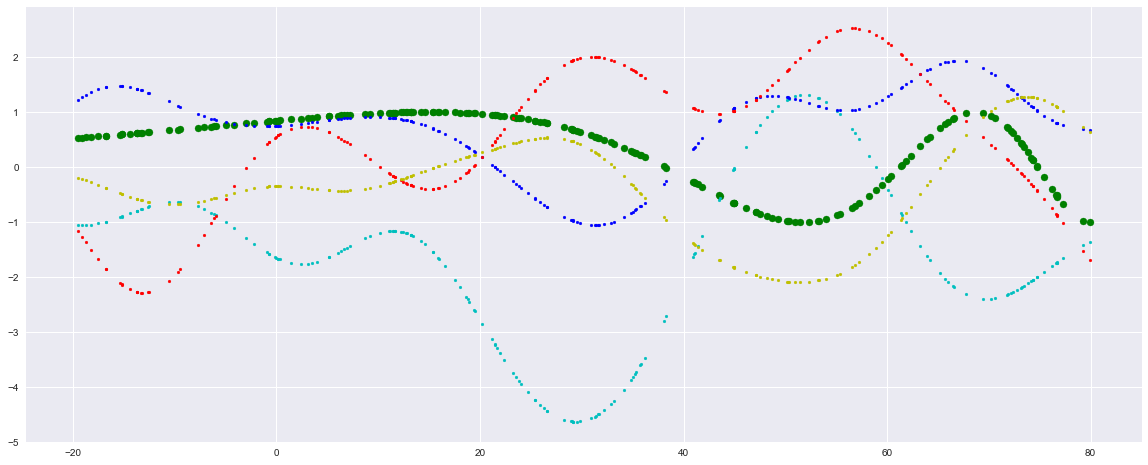

In [155]:
mu = np.zeros(len(x))
r = np.random.multivariate_normal(mu, K, size=4)

#plotting
plt.figure()
plt.scatter(x, t, c="g")
plt.scatter(x, r[0], c="c", s=8)
plt.scatter(x, r[1], c="b", s=8)
plt.scatter(x, r[2], c="r", s=8)
plt.scatter(x, r[3], c="y", s=8)
plt.show()

<h2>4. GP Inference</h2>

<div class="alert alert-success">
Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the data leads to the posterior distribution over functions.
<br><br>
Assign 3 points at random from x (and their corresponding function values) to <code>obs_x</code> and <code>obs_t</code> respectively. We shall also package the kernel parameters as a list, <code>params = [lengthscale, variance, noise]</code>. You are encouraged to use the following initial conﬁguration:
<br>
<code>
lengthscale = 10
variance = 2
noise = 1e-6
</code>
<br>
Download the ﬁle <i>gp_inference.m</i> and complete the provided implementation for evaluating the posterior GP mean and variance using the equations given in the lecture.
<br><br>
<i>Note: As we have encountered in previous labs, matrix inversions can be both numerically troublesome and slow to compute. In this lab, we shall avoid computing direct matrix inversions by instead considering Cholesky decompositions for solving linear systems. The steps for using Cholesky within GP inference are outlined as comments within the provided code. Even so, you are encouraged to read more about Cholesky decompositions for GPs by consulting Appendix A.4 of Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005) - available online!</i>
</div>

In [299]:
def gp_inference(obs_x, obs_t, new_x, lengthscale, variance, noise):
    n = len(obs_x)
    kern_obs = compute_kernel_wrapper(obs_x, obs_x, lengthscale, variance, noise)
    
    #When computing the posterior mean, we would like to avoid evaluating 
    #"alpha = inv(kern_obs)*obs_t" directly. The Cholesky decomposition can
    #be applied using the following procedure.
    #1. Compute the lower-triangular Cholesky decomposition of "kern_obs" ("L")
    #2. Compute alpha as "alpha = L'\(L\obs_t)"
    
    L = np.linalg.cholesky(kern_obs)
    _ = scipy.linalg.solve_triangular(L, obs_t, lower=True)
    alpha = scipy.linalg.solve_triangular(L.T, _, lower=False)
    
    #alpha2 = np.multiply((np.multiply(obs_t, np.invert(L)), np.invert(L.T))
    
    kern_obs_pred = compute_kernel_wrapper(obs_x, new_x, lengthscale, variance) 
    
    kern_pred = compute_kernel_wrapper(new_x, new_x, lengthscale, variance)
    
    post_m = np.dot(kern_obs_pred, alpha)
    
    #Similarly, when computing "v = inv(kern_obs)*kern_obs_pred", 
    #employ the Cholesky decomposition as described above.
    v = np.dot(kern_obs_pred, np.linalg.inv(L))        
    post_V = kern_pred - np.dot(v, np.transpose(v))
    
    #negative log-likelihood
    obs_t = np.asarray(obs_t)
    nll = - (0.5  * obs_t.dot(alpha)) - L.trace()
    #nll = 0
    return (post_m, post_V, nll)

<div class="alert alert-success">
The following box allows us to choose easily the parameters.
</div>

In [297]:
lengthscale = 10
variance = 2
noise = 10**(-6)

nrObservations = 1
nrPoints = 200
nrSamplings = 50

In [303]:
#x = np.random.uniform(low=-20, high=80, size=100)
x = np.arange(-20,80,(80+20)/nrPoints)
t = [fun(_) for _ in x]

obs_x = np.random.choice(x, size=nrObservations, replace=False)
obs_t = [fun(_) for _ in obs_x]

post_m, post_V, nll = gp_inference(obs_x, obs_t, x, lengthscale, variance, noise)
print(nll)

-1.5811492883


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


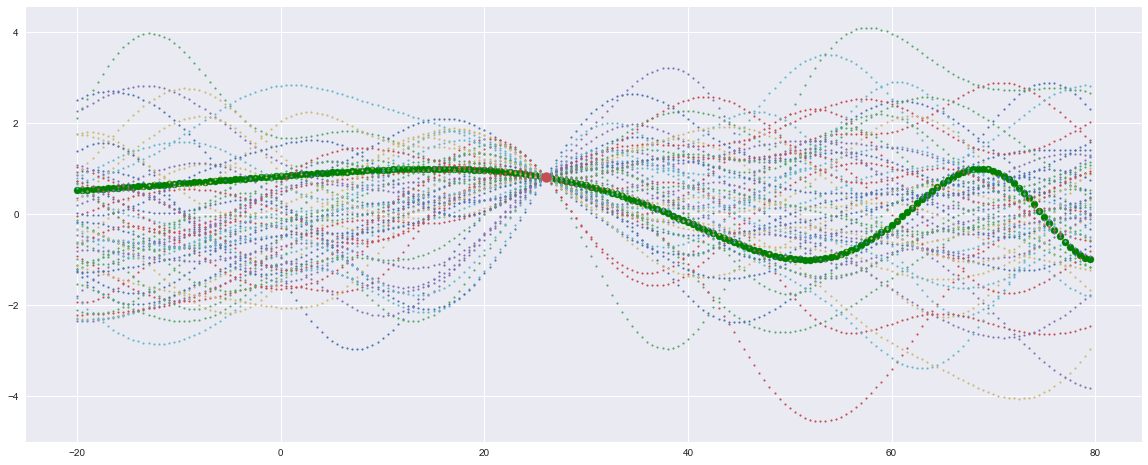

In [295]:
r = np.random.multivariate_normal(post_m, post_V, size=nrSamplings)

#plotting
plt.figure()
plt.scatter(x, t, c="g", s=50)
for _ in r:
    plt.scatter(x, _, s=3)
plt.scatter(obs_x, obs_t, s=100)
plt.show()

<h2>5. Sampling from GP Posterior</h2>

<div class="alert alert-success">
Now that you have computed the posterior mean and variance, create a new ﬁgure once again showing the true function. To this ﬁgure, add the posterior mean and 95% conﬁdence interval.
<br><br>
Note that we should also add the noise variance to the predictive variance of the posterior. Fix this accordingly.
<br><br>
Additionally, as we did with the prior distribution, sample four functions from the posterior and plot them on the same ﬁgure. Comment on what you observe. You should also view how the posterior mean and variance improve when more observations are included in the GP inference procedure.
<br><br>
As a measure of model quality, you should also compute the log marginal likelihood of the model. To this end, complete the code provided in <i>gp_inference</i> to include the $nll$ term. <i>Hint: Refer to Algorithm 2.1 in Chapter 2 of the book referenced above for details on how to compute this term eﬃciently.</i>
</div>